In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import scipy
import os
from scipy.stats import linregress
from datetime import timedelta

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

warnings.filterwarnings("ignore")

from isofit.inversion.inverse_simple import invert_liquid_water

from isofit.core.common import (
    get_refractive_index,
)

plt.rcParams['figure.dpi'] = 300

## 1. Load in and organize data

In [17]:
fielddata_path = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/field_data/LWC_LFM_WP_dates20230525.csv'

cwc_dir_850_1300 = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_850_1300'
cwc_dir_850_1100 = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_850_1100'
cwc_dir_1100_1300 = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_1100_1300'

In [25]:
## reading in and organizing CWC data

# full_date_list = ['20220224', '20220228',  '20220308', '20220316', '20220322', '20220405', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
date_list = ['20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
datetime_list = [datetime.strptime(date, '%Y%m%d') for date in date_list]

# handling for non-convergence in the invert_liquid_water function
def kill_nans(df):
    mask = (df['CWC'] > 0.499962 - 0.0001) & (df['CWC'] < 0.499962 + 0.0001)
    df.loc[mask, 'CWC'] = np.nan
    return df

## first the full baloney of 850-1300nm
cwc_file_paths_850_1300 = [os.path.join(cwc_dir_850_1300, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers
cwc_850_1300 = pd.read_csv(cwc_file_paths_850_1300[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope']).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths_850_1300[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    cwc_850_1300 = cwc_850_1300.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})
# now make a list of dataframes containing all the good stuff
cwc_df_list_850_1300 = []
for date, file_path in zip(date_list, cwc_file_paths_850_1300):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df = cwc_df.drop_duplicates(subset=['CWC', 'datetime'])
    cwc_df_list_850_1300.append(cwc_df)


## now the 850-1100nm...
cwc_file_paths_850_1100 = [os.path.join(cwc_dir_850_1100, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers
cwc_850_1100 = pd.read_csv(cwc_file_paths_850_1100[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope']).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths_850_1100[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    cwc_850_1100 = cwc_850_1100.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})
# now make a list of dataframes containing all the good stuff
cwc_df_list_850_1100 = []
for date, file_path in zip(date_list, cwc_file_paths_850_1100):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df = cwc_df.drop_duplicates(subset=['CWC', 'datetime'])
    cwc_df_list_850_1100.append(cwc_df)


## finally the 1100-1300nm region <3
cwc_file_paths_1100_1300 = [os.path.join(cwc_dir_1100_1300, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers
cwc_1100_1300 = pd.read_csv(cwc_file_paths_1100_1300[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope']).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths_1100_1300[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    cwc_1100_1300 = cwc_1100_1300.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})
# now make a list of dataframes containing all the good stuff
cwc_df_list_1100_1300 = []
for date, file_path in zip(date_list, cwc_file_paths_1100_1300):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df = cwc_df.drop_duplicates(subset=['CWC', 'datetime'])
    cwc_df_list_1100_1300.append(cwc_df)

In [26]:
def beer_lambert_propagation(wl, alpha_lw, cwc, intercept, slope):
    # wl: wavelengths
    # alpha_lw: liquid water absorption coefficient
    # cwc: canopy water content returned by invert_liquid_water
    # intercept: intercept of the linear fit returned by invert_liquid_water
    # slope: slope of the linear fit returned by invert_liquid_water
    
    attenuation = np.exp(-cwc * 1e7 * alpha_lw)
    return (intercept + slope * wl) * attenuation

In [55]:
## load up a random spec
spec_file_path = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/extracted_spectra_by_tree/20220511_tree_spectra.csv'
spec_file = pd.read_csv(spec_file_path, index_col='Unnamed: 0')
wavelengths = np.array(spec_file.index)
wl_nan = wavelengths.copy()
wl_nan[wavelengths < 400] = np.nan 
wl_nan[wavelengths > 2475] = np.nan 
wl_nan[np.logical_and(wavelengths > 1350, wavelengths < 1480)] = np.nan 
wl_nan[np.logical_and(wavelengths > 1800, wavelengths < 1950)] = np.nan 
i = 18
spec = np.array(spec_file.iloc[:, i])

# load up water absorption data
isofit_path = 'C:/Users/jeanallen/MiniConda3/envs/rs/Lib/site-packages'  ## may vary for other users
path_k = os.path.join(isofit_path, "data", "iop", "k_liquid_water_ice.xlsx")
k_wi = pd.read_excel(io=path_k, sheet_name="Sheet1", engine="openpyxl")
wl_water, k_water = get_refractive_index(k_wi=k_wi, a=0, b=982, col_wvl="wvl_6", col_k="T = 20°C")
kw = np.interp(x=wavelengths, xp=wl_water, fp=k_water)
abs_co_w = 4 * np.pi * kw / wavelengths
alpha_lw = abs_co_w

# beer-lambert
left_bound1 = 850
right_bound1 = 1100
cwc1, intercept1, slope1 = invert_liquid_water(np.array(spec_file.iloc[:, i]), wavelengths, l_shoulder=left_bound1, r_shoulder=right_bound1)
beer_lambert1 = beer_lambert_propagation(wavelengths, alpha_lw, cwc1, intercept1, slope1)
left_bound2 = 1100
right_bound2 = 1300
cwc2, intercept2, slope2 = invert_liquid_water(np.array(spec_file.iloc[:, i]), wavelengths, l_shoulder=left_bound2, r_shoulder=right_bound2)
beer_lambert2 = beer_lambert_propagation(wavelengths, alpha_lw, cwc2, intercept2, slope2)
left_bound3 = 850
right_bound3 = 1300
cwc3, intercept3, slope3 = invert_liquid_water(np.array(spec_file.iloc[:, i]), wavelengths, l_shoulder=left_bound3, r_shoulder=right_bound3)
beer_lambert3 = beer_lambert_propagation(wavelengths, alpha_lw, cwc3, intercept3, slope3)

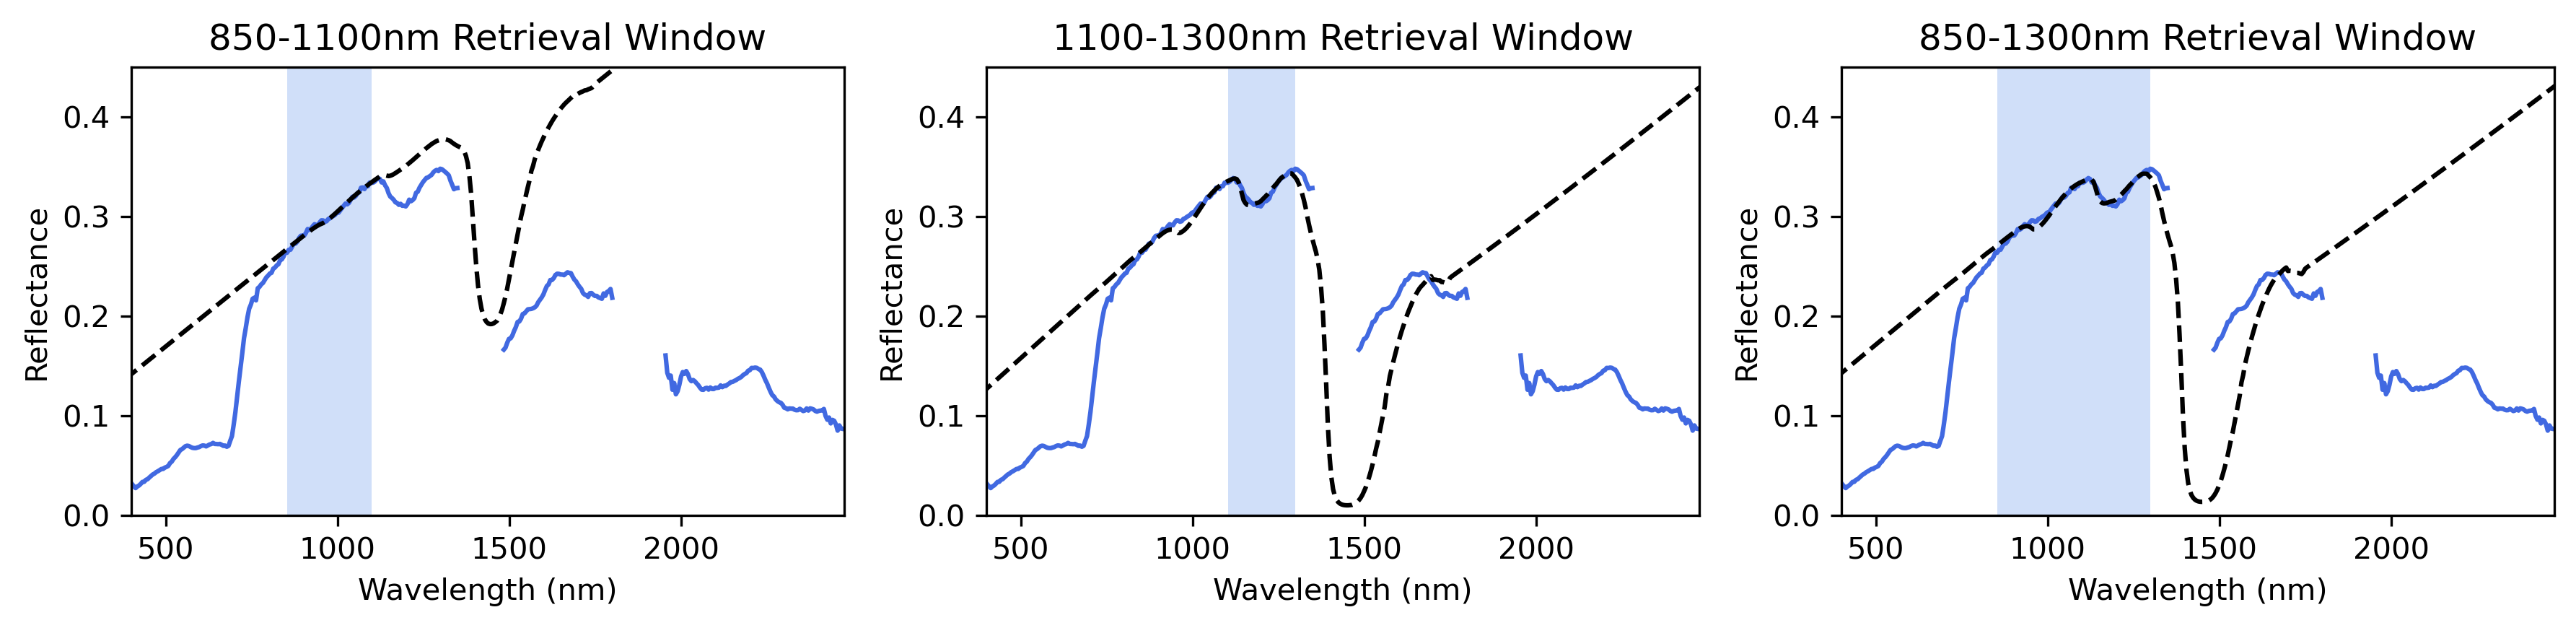

In [ ]:
# plot...
fig, (spec1, spec2, spec3) = plt.subplots(1, 3, figsize=(12, 3))

spec1.plot(wl_nan, spec, label='Reflectance', color='royalblue')
spec1.plot(wavelengths, beer_lambert1, label='Water Absorption', color='black', linestyle='--')
spec1.fill_between(wavelengths, 0, 1, where=np.logical_and(wavelengths > left_bound1, wavelengths < right_bound1), color='cornflowerblue', alpha=0.3, linewidth=0)
spec1.set_xlim(400, 2475)
spec1.set_ylim(0, 0.45)
spec1.set_title('850-1100nm Retrieval Window')
spec1.set_xlabel('Wavelength (nm)')
spec1.set_ylabel('Reflectance')

spec2.plot(wl_nan, spec, label='Reflectance', color='royalblue')
spec2.plot(wavelengths, beer_lambert2, label='Water Absorption', color='black', linestyle='--')
spec2.fill_between(wavelengths, 0, 1, where=np.logical_and(wavelengths > left_bound2, wavelengths < right_bound2), color='cornflowerblue', alpha=0.3, linewidth=0)
spec2.set_xlim(400, 2475)
spec2.set_ylim(0, 0.45)
spec2.set_title('1100-1300nm Retrieval Window')
spec2.set_xlabel('Wavelength (nm)')
spec2.set_ylabel('Reflectance')

spec3.plot(wl_nan, spec, label='Reflectance', color='royalblue')
spec3.plot(wavelengths, beer_lambert3, label='Water Absorption', color='black', linestyle='--')
spec3.fill_between(wavelengths, 0, 1, where=np.logical_and(wavelengths > left_bound3, wavelengths < right_bound3), color='cornflowerblue', alpha=0.3, linewidth=0)
spec3.set_xlim(400, 2475)
spec3.set_ylim(0, 0.45)
spec3.set_title('850-1300nm Retrieval Window')
spec3.set_xlabel('Wavelength (nm)')
spec3.set_ylabel('Reflectance')

plt.tight_layout()
# plt.savefig('./example_specs.png')
plt.show()

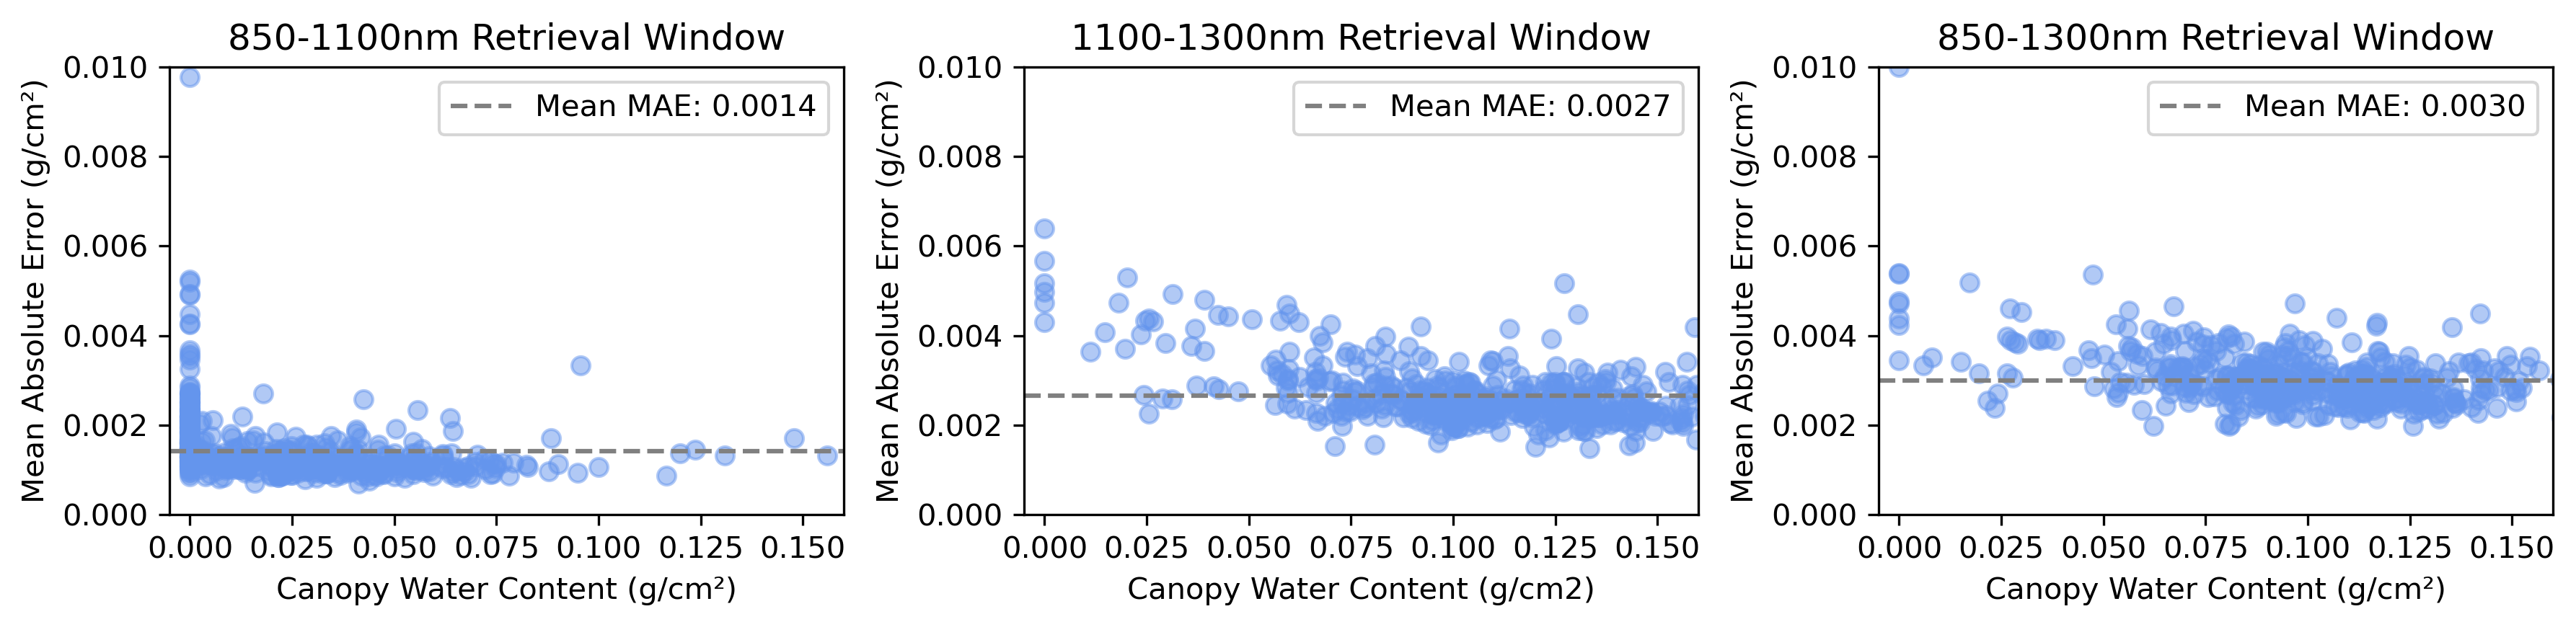

In [65]:
# plot MAE against CWC for all three retrieval windows

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

# 850-1100nm
for i, cwc_df in enumerate(cwc_df_list_850_1100):
    cwc_df = cwc_df.dropna()
    ax1.scatter(cwc_df['CWC'], cwc_df['MAE'], alpha=0.5, color='cornflowerblue')
    slope, intercept, r_value, p_value, std_err = linregress(cwc_df['CWC'], cwc_df['MAE'])
ax1.set_xlabel('Canopy Water Content (g/cm²)')
ax1.set_ylabel('Mean Absolute Error (g/cm²)')
ax1.set_xlim(-0.005, 0.16)
ax1.set_ylim(0, 0.01)
ax1.set_title('850-1100nm Retrieval Window')
mae_mean_850_1100 = np.mean([cwc_df['MAE'].mean() for cwc_df in cwc_df_list_850_1100])
ax1.axhline(y=mae_mean_850_1100, color='gray', linestyle='--', label='Mean MAE: {:.4f}'.format(mae_mean_850_1100))
ax1.legend()

# 1100-1300nm
for i, cwc_df in enumerate(cwc_df_list_1100_1300):
    cwc_df = cwc_df.dropna()
    ax2.scatter(cwc_df['CWC'], cwc_df['MAE'], alpha=0.5, color='cornflowerblue')
    slope, intercept, r_value, p_value, std_err = linregress(cwc_df['CWC'], cwc_df['MAE'])
ax2.set_xlabel('Canopy Water Content (g/cm2)')
ax2.set_ylabel('Mean Absolute Error (g/cm²)')
ax2.set_xlim(-0.005, 0.16)
ax2.set_ylim(0, 0.01)
ax2.set_title('1100-1300nm Retrieval Window')
mae_mean_1100_1300 = np.mean([cwc_df['MAE'].mean() for cwc_df in cwc_df_list_1100_1300])
ax2.axhline(y=mae_mean_1100_1300, color='gray', linestyle='--', label='Mean MAE: {:.4f}'.format(mae_mean_1100_1300))
ax2.legend()

# 850-1300nm
for i, cwc_df in enumerate(cwc_df_list_850_1300):
    cwc_df = cwc_df.dropna()
    ax3.scatter(cwc_df['CWC'], cwc_df['MAE'], alpha=0.5, color='cornflowerblue')
    slope, intercept, r_value, p_value, std_err = linregress(cwc_df['CWC'], cwc_df['MAE'])
ax3.set_xlabel('Canopy Water Content (g/cm²)')
ax3.set_ylabel('Mean Absolute Error (g/cm²)')
ax3.set_xlim(-0.005, 0.16)
ax3.set_ylim(0, 0.01)
ax3.set_title('850-1300nm Retrieval Window')
mae_mean_850_1300 = np.mean([cwc_df['MAE'].mean() for cwc_df in cwc_df_list_850_1300])
ax3.axhline(y=mae_mean_850_1300, color='gray', linestyle='--', label='Mean MAE: {:.4f}'.format(mae_mean_850_1300))
ax3.legend()

plt.tight_layout()
# plt.savefig('./mae_vs_cwc.png')
plt.show()

## 3. Compare 850-1100nm CWC values vs. 1100-1300nm CWC values

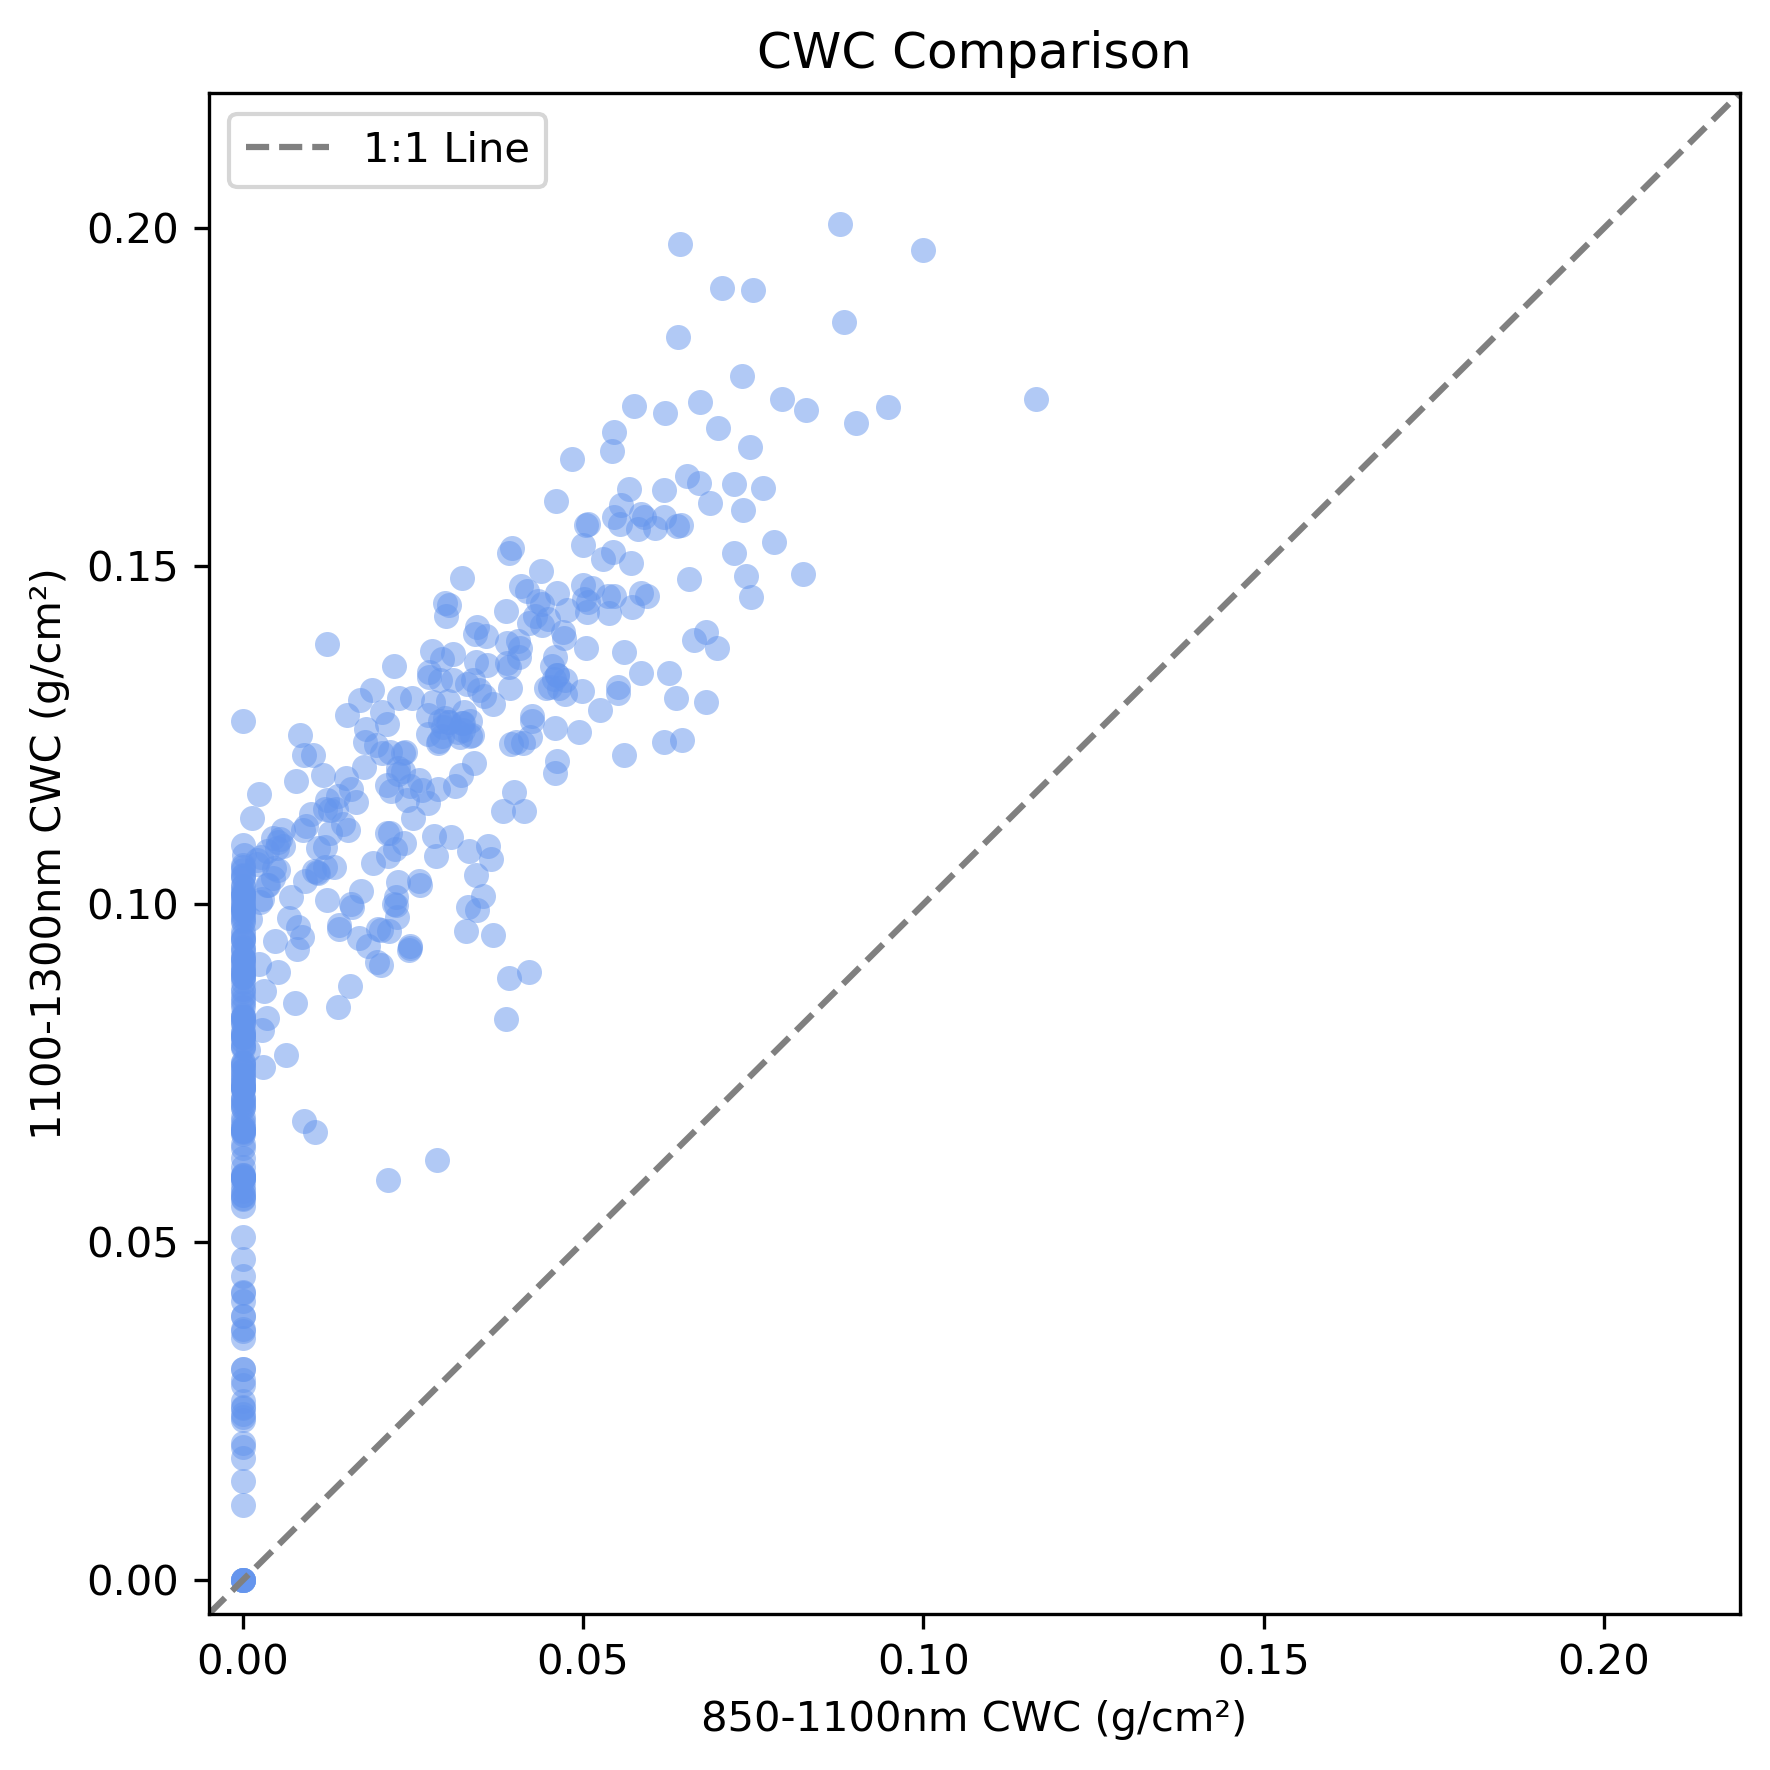

In [ ]:
# plot 850-1100nm CWC against 1100-1300nm CWC
fig, ax = plt.subplots(figsize=(6, 6))

for i, cwc_df in enumerate(cwc_df_list_850_1100):
    cwc_df = cwc_df_list_850_1100[i]
    cwc_df = cwc_df.dropna()
    other_cwc_df = cwc_df_list_1100_1300[i]
    # join based on tree number
    cwc_df = cwc_df.join(other_cwc_df['CWC'], rsuffix='_1100_1300')
    cwc_df = cwc_df.dropna()
    ax.scatter(cwc_df['CWC'], cwc_df['CWC_1100_1300'], alpha=0.5, color='cornflowerblue', linewidth=0)

ax.set_xlabel('850-1100nm CWC (g/cm²)')
ax.set_ylabel('1100-1300nm CWC (g/cm²)')
ax.set_xlim(-0.005, 0.22)
ax.set_ylim(-0.005, 0.22)
# set x ticks to match y ticks
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
# one to one line...
x = np.linspace(-0.005, 0.22, 100)
y = x
ax.plot(x, y, color='gray', linestyle='--', label='1:1 Line')
ax.set_title('CWC Comparison')
ax.legend()

plt.tight_layout()
# plt.savefig('./cwc_comparison.png')
plt.show()